# Baseline Model with BOW + Tf-Idf without text preprocessing

In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [68]:
# unzipping training data
# !unzip ../input/quora-question-pairs/train.csv.zip

In [69]:
# read tarining data
train = pd.read_csv('./train.csv')
train.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate
167577,167577,259776,259777,What exactly happens on the international date...,What is international date line?,0
163587,163587,254424,254425,Which is the best colocation center in New York?,What is the best colocation center in New York?,1
243454,243454,192484,355897,If your spouse and baby were drowning but coul...,So your son and husband are about to drown and...,1
347072,347072,393770,150421,Will Trump’s victory affect the Indian students?,How is the victory of Donald Trump going to af...,0
343298,343298,471397,471398,"I am told that If n = 25, we have Sn = 121392 ...",How can I find and prove a formula for [math]f...,0
95513,95513,98053,60210,As I begin to take in that Donald Trump has be...,Would Donald Trump be a good president?,1
293432,293432,1006,415193,Which European country is the best for asylum ...,Why should a country provide asylum?,0
331734,331734,458651,458652,"Can someone give me the formula for a cheap, h...",How do you counter a C'Thun deck?,0
269078,269078,386731,207757,Have you ever had sex with a family relative?,Have you ever had sex with your cousin?,0
403780,403780,537384,537385,What is your USP?,Should Wikipedia have a comment section?,0


In [70]:
train.shape

(404290, 6)

In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [72]:
# null values in complete dataset
train.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [73]:
# Null value in question1
train[train.question1.isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [74]:
# Null value in question2
train[train.question2.isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


we already have lots of data so we can safely remove these 3 missing values 

In [75]:
#drop samples with missing values
train.dropna(axis = 0, inplace = True)
train.shape

(404287, 6)

In [76]:
# Similar questions
train['question1'].iloc[190123],train['question2'].iloc[190123]

('Why is it irritating to rub your nails against a blackboard or a wall?',
 "Is There any adverse effect on rubbing both hand's nails against each other ?")

In [77]:
# Similar questions
train['question1'].iloc[95847],train['question2'].iloc[95847]

('What in our opinion are the top 5 best books of all time?',
 'What are some of the best books ever written?')

In [78]:
# Different questions
train['question1'].iloc[125695],train['question2'].iloc[125695]

('What are 3 things people can learn from Mashable?',
 "What is the thing which you can't learn from a course?")

<AxesSubplot:>

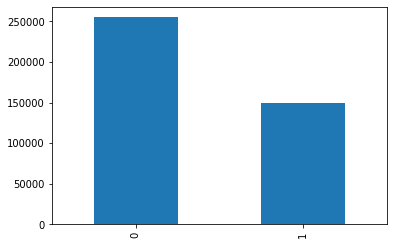

In [79]:
# non duplicate and duplicate question count plot 
train['is_duplicate'].value_counts().plot.bar()

In [80]:
# Unique question ids in the dataset
qid = pd.Series(train['qid1'].tolist()+train['qid2'].tolist())
print("No. of unique question ids : ", len(np.unique(qid)))
# Duplicate question ids in the dataset
x = pd.Series(train['qid1'].tolist()+train['qid2'].tolist()).value_counts()>1
print("No. of repeated questions : ",x[x].shape[0])

# duplicate question pairs 
print("No. of duplicate question pairs : ",train.duplicated().sum())

No. of unique question ids :  537929
No. of repeated questions :  111778
No. of duplicate question pairs :  0


In [81]:
# take only 30k samples, complete data is too big to store in RAM
new_df = train.sample(30000)

# only question1 and question2 extracted from dataframe
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
393277,Can I find someone's Gmail address by their name?,How do I find someone's Gmail account associat...
148805,(UK) How do you calculate the value of a lease...,How is a charity organization run and taxed in...
396091,What proof is there that the earth is not flat?,Is this proof that the Earth is flat?
168692,How do I improve my pronunciation of English?,How can I speaking fluently speaking English?
214258,Rooting (Android): How do I unbrick Moto E2 (3...,Where can I get the Moto G2 Indian Version(Xt1...


In [82]:
# to implement bag of words
from sklearn.feature_extraction.text import CountVectorizer

# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

# max_feature is 3000 because keeping all features causing notebook crash due to limited RAM size 
cv = CountVectorizer(max_features = 3000)

# vsplit function split an array into multiple sub-arrays vertically (row-wise).
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

# numpy to data frame conversion to concate the data coulm wise(side by side)
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [83]:
temp_df['is_duplicate'] = new_df['is_duplicate']

In [84]:
# train test split, 20% data for testing 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1].values,test_size=0.2,random_state=1)

In [85]:
%%time
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test,y_pred)

CPU times: user 22.2 s, sys: 2.28 s, total: 24.5 s
Wall time: 6.65 s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.696

In [86]:
%%time
# random forest classifier with default parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)


CPU times: user 1min, sys: 334 ms, total: 1min
Wall time: 1min


0.7343333333333333

In [87]:
# SVC takes a lot of time to run 
# from sklearn.svm import SVC
# svc = SVC()
# svc.fit(X_train,y_train)
# y_pred = svc.predict(X_test)
# accuracy_score(y_test,y_pred)

In [88]:
%%time
# xgboost classifier
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)


CPU times: user 14min 15s, sys: 945 ms, total: 14min 16s
Wall time: 3min 38s


0.725

In [89]:
%%time
# Tf-Idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# object for tf-idf vectorization 
tf = TfidfVectorizer(max_features = 3000)

# vsplit function split an array into multiple sub-arrays vertically (row-wise).
q1_arr, q2_arr = np.vsplit(tf.fit_transform(questions).toarray(),2)

# numpy to data frame conversion to concate the data coulm wise(side by side)
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df['is_duplicate'] = new_df['is_duplicate']

# train test split same as above
X_train,X_test,y_train,y_test = train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1].values,test_size=0.2,random_state=1)

# Logistic regression
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Logistic Regression Accuracy score : ",accuracy_score(y_test,y_pred))

# random forest classifier with default parameters
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("Random forest Accuracy score : ",accuracy_score(y_test,y_pred))

# xgb classifier 
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
print("XGBoost Accuracy score : ",accuracy_score(y_test,y_pred))


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression Accuracy score :  0.7176666666666667
Random forest Accuracy score :  0.7348333333333333
XGBoost Accuracy score :  0.7166666666666667
CPU times: user 15min 50s, sys: 3.61 s, total: 15min 54s
Wall time: 4min 51s


Here Logistic regression has improved but Random forest hasn't improved much... we can fine tune the model and increase the data to improve the performance